In [1]:
import numpy as np
import cv2


In [2]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# display function to show image on Jupyter
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

In [4]:
# Load the COCO class labels in which our YOLO model was trained on

labelsPath = os.path.join("darknet/data/yolo.names")
LABELS = open(labelsPath).read().strip().split("\n")

In [5]:
# The COCO dataset contains 80 different classes
LABELS

['gun']

In [6]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join("darknet/data/yolov3_900.weights")
configPath = os.path.join("darknet/cfg/yolov3_custom_test.cfg")

In [7]:
# Loading the neural network framework Darknet (YOLO was created based on this framework)
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [8]:
# Create the function which predict the frame input
def predict(image):
    

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]

    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getUnconnectedOutLayersNames()


    # construct a blob from the input image and then perform a forward pass of the YOLO object detector,
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (255,0,0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2)
    return image
# Create the function to detect if a gun is present in the frame
def detect_gun(processed_frame):
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = processed_frame.shape[:2]

    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getUnconnectedOutLayersNames()

    # construct a blob from the input image and then perform a forward pass of the YOLO object detector,
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(processed_frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    threshold = 0.2

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold and LABELS[classID] == 'gun':
                return True  # Gun detected

    return False  # Gun not detected


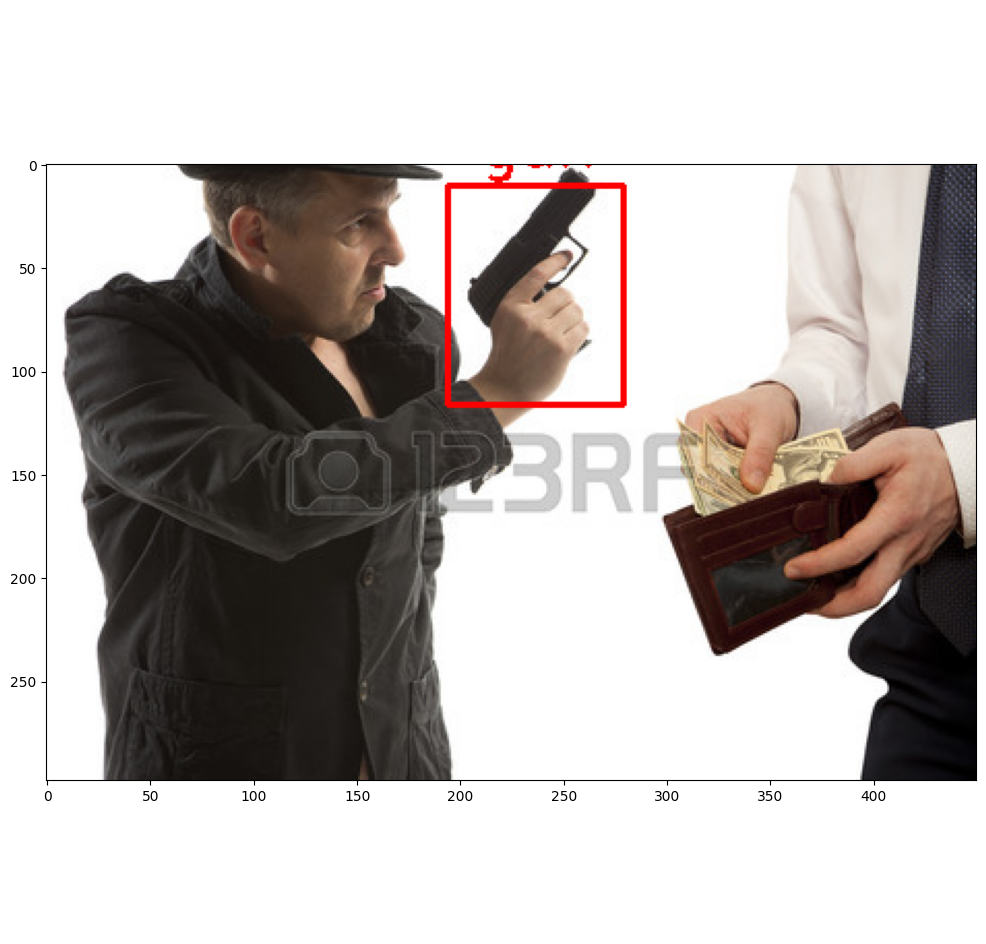

In [9]:
# Execute prediction on a single image
img = cv2.imread("darknet/data/images/armas (150).jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

In [13]:
#WEBCAM CAPTURE TO CAPTURE EXTERNAL DEVICES
import cv2

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform object detection on the frame
    processed_frame = predict(frame)  # Your predict function
    
    # Display the processed frame
    cv2.imshow('Object Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

In [14]:
import cv2

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Get the frame width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can also use other codecs like 'MJPG'
out = cv2.VideoWriter('output.avi', fourcc, 12.0, (frame_width, frame_height))

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform object detection on the frame
    processed_frame = predict(frame)  # Your predict function
    
    # Write the processed frame to the output video file
    out.write(processed_frame)
    
    # Display the processed frame
    cv2.imshow('Object Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoWriter object
out.release()

# Release the webcam capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

In [23]:
import cv2
from pushbullet import Pushbullet

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Initialize Pushbullet with your API key
pb = Pushbullet("o.Jad70f2nLyakB8p7LRPO50iP6WLnAMal")

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    processed_frame = predict(frame)
    # Perform object detection on the frame
    # Assuming predict function returns the detected object coordinates
    gun_detected = False  # Flag to check if gun is detected
    # Your object detection code here
    
    # Check if 'gun' is detected
    if gun_detected:
        # Send a notification to your phone
        push = pb.push_note("Gun Detected", "A gun has been detected in the captured image!")
    
    # Display the processed frame (you might want to add bounding boxes here)
    cv2.imshow('Object Detection', processed_frame)
    
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam capture
cap.release() 

# Close all OpenCV windows
cv2.destroyAllWindows()


In [15]:
processed_frame[0]

array([[108, 108, 108],
       [111, 109, 109],
       [110, 108, 108],
       ...,
       [175, 170, 163],
       [176, 171, 165],
       [179, 173, 167]], dtype=uint8)

In [33]:
import cv2
import time
from pushbullet import Pushbullet

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Initialize Pushbullet with your API key
pb = Pushbullet("o.Jad70f2nLyakB8p7LRPO50iP6WLnAMal")

notification_send = False

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process the frame (e.g., object detection)
    processed_frame = predict(frame)
    
    # Check if gun is detected (replace with your detection logic)
    
    
    # Send notification if gun is detected
    if  notification_send==False:
        try:
            push = pb.push_note("Gun Detected", "A gun has been detected in the captured image!")
            notification_send = True
            print("Notification sent successfully")
        except Exception as e:
            print("Error sending notification:", e)
    
    # Display the processed frame
    cv2.imshow('Object Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam capture
cap.release() 

# Close all OpenCV windows
cv2.destroyAllWindows()


Notification sent successfully


In [10]:
import cv2
from pushbullet import Pushbullet

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Initialize Pushbullet with your API key
pb = Pushbullet("o.Jad70f2nLyakB8p7LRPO50iP6WLnAMal")

notification_send = False

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process the frame (e.g., object detection)
    processed_frame = predict(frame)
    
    # Check if gun is detected (replace with your detection logic)
    
    # Assuming you have a function detect_gun() that returns True if a gun is detected
    if detect_gun(processed_frame) and not notification_send:
        # Save the captured image
        cv2.imwrite('gun_detected.jpg', processed_frame)
        
        # Send the image using Pushbullet
        try:
            with open('gun_detected.jpg', 'rb') as f:
                file_data = pb.upload_file(f, 'gun_detected.jpg')
            push = pb.push_file(**file_data)
            push = pb.push_note("Gun Detected", "A gun has been detected in the captured image!")
            notification_send = True
            print("Image sent successfully")
        except Exception as e:
            print("Error sending image:", e)
    
    # Display the processed frame
    cv2.imshow('Object Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam capture
cap.release() 

# Close all OpenCV windows
cv2.destroyAllWindows()


Image sent successfully


In [ ]:
import cv2
from pushbullet import Pushbullet
from datetime import datetime
from geopy.geocoders import Nominatim

# Load the pre-trained YOLO model and class labels
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
LABELS = ['gun']  # List of class labels

# Specify the index of the external webcam (adjust as needed)
external_cam_index = 0  # Use 1 for the first external webcam, 2 for the second, and so on

# Get your current location 
geolocator = Nominatim(user_agent="my_location_app")
location = geolocator.geocode("Sahrdaya College of Engineering and Technology")

# Check if location is found
if location:
    current_location = f"Location: {location}"
else:
    current_location = "Location not found"

# Initialize webcam capture using the external webcam
cap = cv2.VideoCapture(external_cam_index)

# Check if the external webcam is opened successfully
if not cap.isOpened():
    print("Error: External webcam could not be opened")
    exit()

# Initialize video writer for output video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

# Initialize Pushbullet with your API key
pb = Pushbullet("o.Jad70f2nLyakB8p7LRPO50iP6WLnAMal")

notification_send = False

# Loop to capture frames from the external webcam
while True:
    # Read a frame from the external webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process the frame (e.g., object detection)
    processed_frame = predict(frame)
    
    # Check if gun is detected (replace with your detection logic)
    
    # Assuming you have a function detect_gun() that returns True if a gun is detected
    if detect_gun(processed_frame) and not notification_send:
        # Save the captured image
        cv2.imwrite('gun_detected.jpg', processed_frame)
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Send the image using Pushbullet
        try:
            with open('gun_detected.jpg', 'rb') as f:
                file_data = pb.upload_file(f, 'gun_detected.jpg')
            push = pb.push_file(**file_data)
            push = pb.push_note("Gun Detected", body=f"A gun has been detected in the captured image at {current_time} and {current_location}")
            notification_send = True
            print("Image sent successfully")
        except Exception as e:
            print("Error sending image:", e)
    
    # Write the frame to the output video
    out.write(processed_frame)
    
    # Display the processed frame
    cv2.imshow('Object Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video writer and webcam capture
out.release()
cap.release() 

# Close all OpenCV windows
cv2.destroyAllWindows()